In [23]:
import pandas as pd
import seaborn as sns
import rdkit
import torch
import vina
import meeko
import pexpect
import pickle
import numpy as np
from scipy.stats import norm
from typing import Optional, Union, List
from bayes_opt import BayesianOptimization
from bayes_opt.util import load_logs
from bayes_opt.domain_reduction import DomainTransformer
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.target_space import TargetSpace
import dimorphite_dl
import sys
from contextlib import redirect_stdout
latent_size=56

In [3]:
cmd = "conda run -n jtvae --no-capture-output python sample.py --nsample 3 --vocab data/zinc/vocab.txt --hidden 450 --depth 3 --latent 56 --model molvae/MPNVAE-h450-L56-d3-beta0.005/model.iter-4"  # launch your python2 script

class vaeinterface:
    def __init__(self):
        self.dim=dimorphite_dl.DimorphiteDL(min_ph=7.4,max_ph=7.4,max_variants=1)
        pass
    def start(self):
        self.p=pexpect.spawn(cmd,timeout=1200,logfile=open('mylog.txt','wb'))
    def decode(self,all_vec):
        p=self.p
        p.expect("ready")
        tree_vec = all_vec[:,0:latent_size//2].astype("f")
        mol_vec = all_vec[:,latent_size//2:].astype("f")
        pickle.dump([tree_vec,mol_vec],open("molvec.pk1","wb"),protocol=2)
        p.sendline("'go'")
        p.expect("~.*~")
        mol=p.after.decode()[1:-1]
        return mol
        #if mol=="failed":
        #    return mol
        #try:
        #    protmol = self.dim.protonate(mol)
        #    return protmol[0]
        #except:
        #    return mol
    def debug(self):
        p = self.p
        p.expect("ready")
        p.sendline("'go'")
        p.expect("~.*~")
        mol=p.after.decode()[1:-1]
        print(mol)
        protmol = self.dim.protonate(mol)
        print(protmol[0])
    def encode(self,mol):
        p=self.p
        p.expect("ready")
        p.sendline("'enc"+mol+"'")
        p.expect("done")
        all_vec = pickle.load(open("encoded.pk1","rb"),encoding="latin1")
        return all_vec
    def reconstruct(self,mol):
        p=self.p
        all_vec = self.encode(mol)
        return self.decode(all_vec)
        
    def stop(self):
        p=self.p
        p.sendline("'stop'")

def visualise(molecules):
    img = rdkit.Chem.Draw.MolsToGridImage([rdkit.Chem.MolFromSmiles(mol) for mol in molecules],subImgSize=(300,300))
    return img

class vinainterface:
    def __init__(self,receptor,center):
        v = vina.Vina(sf_name='vinardo', verbosity=0)
        v.set_receptor(receptor)
        v.compute_vina_maps(center=center, box_size=[30, 30, 30])
        self.v=v
        self.predicted = {}
        self.receptor = receptor
        self.center = center
        print("Vina Initialisation complete")
    def predict(self,molecule,exhaustiveness):
        if molecule=="failed":
            return -5.0,-1
        if molecule in self.predicted:
            print("SEEN")
            return self.predicted[molecule],1
        lig = rdkit.Chem.MolFromSmiles(molecule)
        protonated_lig = rdkit.Chem.AddHs(lig)
        success = rdkit.Chem.AllChem.EmbedMolecule(protonated_lig)
        if success==-1:
            success=rdkit.Chem.AllChem.EmbedMolecule(protonated_lig, useRandomCoords = True)
        if success==-1:
            print("failed conformer gen")
            return -5.0,-1
        v=self.v
        meeko_prep = meeko.MoleculePreparation()
        meeko_prep.prepare(protonated_lig)
        lig_pdbqt = meeko_prep.write_pdbqt_string()
        v.set_ligand_from_string(lig_pdbqt)
        v.dock(exhaustiveness=exhaustiveness, n_poses=20)
        en=np.sum(v.energies(n_poses=1)[0][1:4])
        self.predicted[molecule]=en
        return en,1
    
class sminainterface:
    def __init__(self,receptor,center):
        self.receptor = receptor
        self.center = center
        self.predicted = {}
    def predict(self,molecule,exhaustiveness):
        if molecule=="failed":
            return -5.0
        if molecule in self.predicted:
            print("SEEN")
            return self.predicted[molecule]
        center = self.center
        receptor = self.receptor
        lig = rdkit.Chem.MolFromSmiles(molecule)
        rdkit.Chem.MolToMolFile(lig,"current_lig.mol")
        !Jupyter_Dock/bin/smina -r {receptor} -l {'current_lig.mol'} -o {'mol_out.sdf'} --center_x {center[0]} --center_y {center[1]} --center_z {center[2]} --size_x {30} --size_y {30} --size_z {30} --exhaustiveness {exhaustiveness} --num_modes 1 --scoring vinardo -q
        poses=rdkit.Chem.SDMolSupplier('mol_out.sdf')

        aff = float(poses[0].GetProp("minimizedAffinity"))
        self.predicted[molecule] = aff
        return aff

class qvinainterface:
    def __init__(self,receptor,center):
        self.receptor = receptor
        self.center = center
        self.predicted = {}
    def predict(self,molecule,exhaustiveness):
        if molecule=="failed":
            return -5.0
        if molecule in self.predicted:
            print("SEEN")
            return self.predicted[molecule]
        center = self.center
        receptor = self.receptor
        lig = rdkit.Chem.MolFromSmiles(molecule)
        protonated_lig = rdkit.Chem.AddHs(lig)
        success = rdkit.Chem.AllChem.EmbedMolecule(protonated_lig)
        meeko_prep = meeko.MoleculePreparation()
        meeko_prep.prepare(protonated_lig)
        lig_pdbqt = meeko_prep.write_pdbqt_file("current_lig.pdbqt")
        !Jupyter_Dock/bin/qvina2.1 --receptor {receptor} --ligand current_lig.pdbqt --out out.pdbqt --center_x {center[0]} --center_y {center[1]} --center_z {center[2]} --size_x {30} --size_y {30} --size_z {30} --exhaustiveness {exhaustiveness} --num_modes 1
        f=open('out.pdbqt')
        lines=f.readlines()
        aff = float(lines[1].split()[3])
        self.predicted[molecule] = aff
        return aff


knowndrugs = {"Gilteritinib":r"CCc1nc(C(=O)N)c(Nc2ccc(N3CCC(CC3)N4CCN(C)CC4)c(OC)c2)nc1NC5CCOCC5", 
              "Quizartinib":r"CC(C)(C)c1cc(no1)NC(=O)Nc2ccc(cc2)c3cn4c5ccc(cc5sc4n3)OCCN6CCOCC6", 
              "Crenolanib":r"O(c5cc4ncn(c1nc3c(cc1)cccc3N2CCC(N)CC2)c4cc5)CC6(COC6)C",
              "Tandutinib":r"CC(C)OC1=CC=C(C=C1)NC(=O)N2CCN(CC2)C3=NC=NC4=CC(=C(C=C43)OC)OCCCN5CCCCC5",
              "Sorafenib":r"CNC(=O)c1cc(ccn1)Oc2ccc(cc2)NC(=O)Nc3ccc(c(c3)C(F)(F)F)Cl",
              "Sunitinib":r"CCN(CC)CCNC(=O)c1c(c([nH]c1C)/C=C\2/c3cc(ccc3NC2=O)F)C",
              "Lestaurtinib":r"C[C@@]12[C@](C[C@@H](O1)n3c4ccccc4c5c3c6n2c7ccccc7c6c8c5C(=O)NC8)(CO)O",
              "Midostaurin":r"C[C@@]12[C@@H]([C@@H](C[C@@H](O1)N3C4=CC=CC=C4C5=C6C(=C7C8=CC=CC=C8N2C7=C53)CNC6=O)N(C)C(=O)C9=CC=CC=C9)OC",
              "Ponatinib":r"Cc1ccc(cc1C#Cc2cnc3n2nccc3)C(=O)Nc4ccc(c(c4)C(F)(F)F)CN5CCN(CC5)C"
              }
fps = {x:rdkit.Chem.RDKFingerprint(rdkit.Chem.MolFromSmiles(knowndrugs[x])) for x in knowndrugs}
def simsearch(molecule):
    if molecule=="failed":
        return 0,0
    molfing = rdkit.Chem.RDKFingerprint(rdkit.Chem.MolFromSmiles(molecule))
    highestsim = 0
    bestmolec = ""
    for fp in fps:
        currsim = rdkit.DataStructs.FingerprintSimilarity(fps[fp],molfing)
        if currsim>highestsim:
            highestsim=currsim
            bestmolec = fp
    return highestsim,bestmolec

In [48]:
class SequentialDomainReductionTransformer(DomainTransformer):
    """
    A sequential domain reduction transformer bassed on the work by Stander, N. and Craig, K:
    "On the robustness of a simple domain reduction scheme for simulation‐based optimization"
    """

    def __init__(
        self,
        gamma_osc: float = 0.7,
        gamma_pan: float = 1.0,
        eta: float = 0.9,
        prob = 0.2
    ) -> None:
        self.gamma_osc = gamma_osc
        self.gamma_pan = gamma_pan
        self.eta = eta
        self.prob = prob

    def initialize(self, target_space: TargetSpace) -> None:
        """Initialize all of the parameters"""
        self.original_bounds = np.copy(target_space.bounds)
        self.bounds = [self.original_bounds]

        self.previous_optimal = np.mean(target_space.bounds, axis=1)
        self.current_optimal = np.mean(target_space.bounds, axis=1)
        self.r = target_space.bounds[:, 1] - target_space.bounds[:, 0]

        self.previous_d = 2.0 * \
            (self.current_optimal - self.previous_optimal) / self.r

        self.current_d = 2.0 * (self.current_optimal -
                                self.previous_optimal) / self.r

        self.c = self.current_d * self.previous_d
        self.c_hat = np.sqrt(np.abs(self.c)) * np.sign(self.c)

        self.gamma = 0.5 * (self.gamma_pan * (1.0 + self.c_hat) +
                            self.gamma_osc * (1.0 - self.c_hat))

        self.contraction_rate = self.eta + \
            np.abs(self.current_d) * (self.gamma - self.eta)

        self.r = self.contraction_rate * self.r

    def _update(self, target_space: TargetSpace) -> None:

        # setting the previous
        self.previous_optimal = self.current_optimal
        self.previous_d = self.current_d

        self.current_optimal = target_space.params[
            np.argmax(target_space.target)
        ]

        self.current_d = 2.0 * (self.current_optimal -
                                self.previous_optimal) / self.r

        self.c = self.current_d * self.previous_d

        self.c_hat = np.sqrt(np.abs(self.c)) * np.sign(self.c)

        self.gamma = 0.5 * (self.gamma_pan * (1.0 + self.c_hat) +
                            self.gamma_osc * (1.0 - self.c_hat))

        self.contraction_rate = self.eta + \
            np.abs(self.current_d) * (self.gamma - self.eta)

        self.r = self.contraction_rate * self.r

    def _trim(self, new_bounds: np.array, global_bounds: np.array) -> np.array:
        prob = self.prob
        #make symmetric interval about current best with area prob
        #this could be optimised but is good enough for our purpose
        self.minimum_window = np.repeat(self.current_optimal[:,None],2,axis=1)
        for i in range(new_bounds.shape[0]):
            while norm.cdf(self.minimum_window[i,1])-norm.cdf(self.minimum_window[i,0])<prob:
                if self.minimum_window[i,1]<global_bounds[i,1]:
                    self.minimum_window[i,1]+=0.05
                if self.minimum_window[i,0]>global_bounds[i,0]:
                    self.minimum_window[i,0]-=0.05
        for i in range(new_bounds.shape[0]):
            if new_bounds[i,0]>self.minimum_window[i,0]:
                new_bounds[i,0]=self.minimum_window[i,0]
            if new_bounds[i,1]<self.minimum_window[i,1]:
                new_bounds[i,1]=self.minimum_window[i,1]
            if new_bounds[i,0]<global_bounds[i,0]:
                new_bounds[i,0]=global_bounds[i,0]
            if new_bounds[i,1]>global_bounds[i,1]:
                new_bounds[i,1]=global_bounds[i,1]

        return new_bounds

    def _create_bounds(self, parameters: dict, bounds: np.array) -> dict:
        return {param: bounds[i, :] for i, param in enumerate(parameters)}

    def transform(self, target_space: TargetSpace) -> dict:

        self._update(target_space)

        new_bounds = np.array(
            [
                self.current_optimal - 0.5 * self.r,
                self.current_optimal + 0.5 * self.r
            ]
        ).T

        self._trim(new_bounds, self.original_bounds)
        self.bounds.append(new_bounds)
        return self._create_bounds(target_space.keys, new_bounds)

In [55]:
from hide_warnings import hide_warnings

beta = 4184/(8.3145*310)
pred_list = []

@hide_warnings(out=False)
def optstart(numiters):
    ind=0
    print("Starting")
    flt3 = vinainterface("receptorstruc.pdbqt",[-28.03685,	-10.361925,	-28.9883])
    ckit = vinainterface("ckit.pdbqt",[45.93035714,	97.03574286,	16.1472])
    pdgfra = vinainterface("pdgfra.pdbqt",[17.58837931,	132.5595172,	-6.030275862])
    vegfr = vinainterface("VEGFR.pdbqt",[25.997,	28.605,	17.134])
    mk2 = vinainterface("MK2.pdbqt",[47.6395,	34.809,	16.708])
    jak2 = vinainterface("JAK2.pdbqt",[-31.7445,	-49.661,	35.4655])
      
    def optfunction(**kwargs):
        nonlocal ind
        ind+=1
        mol=vaeint.decode(np.expand_dims(np.fromiter(kwargs.values(),dtype=float),axis=0))
        exh = 8
        flt3_pred,success = flt3.predict(mol,exh)
        if success!=-1:
            pdgfra_pred = pdgfra.predict(mol,exh)[0]
            ckit_pred = ckit.predict(mol,exh)[0]
            vegfr_pred = vegfr.predict(mol,exh)[0]
            mk2_pred = mk2.predict(mol,exh)[0]
            jak2_pred = jak2.predict(mol,exh)[0]
        else:
            pdgfra_pred = -5.0
            ckit_pred = -5.0
            vegfr_pred = -5.0
            mk2_pred =-5.0
            jak2_pred = -5.0
        all_preds = [flt3_pred,pdgfra_pred,ckit_pred,vegfr_pred,mk2_pred,jak2_pred]

        anybind=-6.0

        prediction = np.exp(-beta*flt3_pred)/(np.exp(-beta*anybind)+np.sum([np.exp(-beta*pr) for pr in all_preds]))
        pred_list.append([mol,prediction,all_preds])

        sim,molec = simsearch(mol)
        print(f"{ind}: {mol}, Pred: {prediction:.4f}, SimDrug: {molec}, SimVal: {sim:.3f}")
        print(f"FLT3: {flt3_pred:.2f}, PDGFRA: {pdgfra_pred:.2f}, CKIT: {ckit_pred:.2f}, VEGFR: {vegfr_pred:.2f}, MK2: {mk2_pred:.2f}, JAK2: {jak2_pred:.2f}")
        
        return prediction

    pbounds = {f"f{i}": (-3,3) for i in range(56)}
    bounds_transformer = SequentialDomainReductionTransformer(prob=0.3)
    optimizer = BayesianOptimization(f=optfunction,pbounds=pbounds,verbose=0,bounds_transformer=bounds_transformer)
    logger = JSONLogger(path="./testing.json")
    optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)
    optimizer.set_gp_params(alpha=0.1)
    #load_logs(optimizer, logs=["./initial100.json"])
    vaeint=vaeinterface()
    vaeint.start()
    optimizer.maximize(init_points=0,n_iter=numiters)
    vaeint.stop()
optstart(200)
pickle.dump(pred_list,open("500pred_list_minwin1.pk1","wb"),protocol=2)

Starting
Vina Initialisation complete
Vina Initialisation complete
Vina Initialisation complete
Vina Initialisation complete
Vina Initialisation complete
Vina Initialisation complete
1: failed, Pred: 0.0903, SimDrug: 0, SimVal: 0.000
FLT3: -5.00, PDGFRA: -5.00, CKIT: -5.00, VEGFR: -5.00, MK2: -5.00, JAK2: -5.00
2: CNC(=O)[C@H]1CN(C(=O)c2ccc3c(c2)N(C)C(=O)CN3)[C@@H]1C, Pred: 0.0869, SimDrug: Midostaurin, SimVal: 0.408
FLT3: -5.35, PDGFRA: -5.24, CKIT: -5.93, VEGFR: -5.82, MK2: -4.90, JAK2: -5.63
3: N#C[C@]1(N)O[C@@H](N2CCN(C(=O)c3ccccc3-c3nccs3)CC2)c2ccccc21, Pred: 0.1256, SimDrug: Midostaurin, SimVal: 0.547
FLT3: -6.00, PDGFRA: -5.91, CKIT: -5.84, VEGFR: -5.90, MK2: -4.94, JAK2: -6.73
4: C[C@H]1CN(C(=O)c2ccccc2C(F)(F)F)[C@@](c2ccccc2)(C2C3CC4CC(C3)CC2C4)[C@H](C)O1, Pred: 0.3711, SimDrug: Midostaurin, SimVal: 0.604
FLT3: -6.88, PDGFRA: -6.32, CKIT: -6.90, VEGFR: -3.63, MK2: -3.67, JAK2: -3.51
5: C[C@H]1CCCCN1C(=O)c1cccc2c(-c3ccccn3)nn([C@@]3(C#N)CCCO3)c12, Pred: 0.1390, SimDrug: Midosta

In [56]:
pickle.dump(pred_list,open("200pred_list_prob03.pk1","wb"),protocol=2)

In [57]:
pbounds = {f"f{i}": (-3,3) for i in range(56)}
bounds_transformer = SequentialDomainReductionTransformer(prob=0.5)
optimizer = BayesianOptimization(f=optstart,pbounds=pbounds,verbose=0,bounds_transformer=bounds_transformer)
load_logs(optimizer, logs=["./200prob03.json"])


[Text(0.5, 0, 'Iteration'), Text(0, 0.5, 'Objective')]

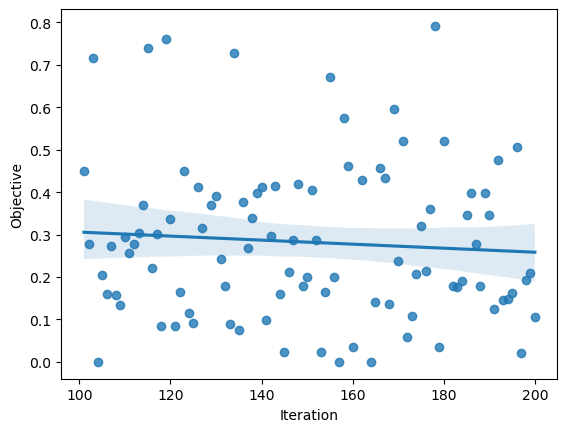

In [58]:
seenpreds = set()
predplot = []
x=[]
for i,pred in enumerate(optimizer.res):
    if pred["target"] not in seenpreds and i>100:
        predplot.append(pred["target"])
        x.append(i)
        seenpreds.add(pred["target"])
ax=sns.regplot(x=x,y=predplot)
ax.set(xlabel="Iteration",ylabel="Objective")


In [36]:
from hide_warnings import hide_warnings
@hide_warnings(out=False)
def knowndrugeval():
    beta = 4184/(8.3145*310)
    flt3 = vinainterface("receptorstruc.pdbqt",[-28.03685,	-10.361925,	-28.9883])
    ckit = vinainterface("ckit.pdbqt",[45.93035714,	97.03574286,	16.1472])
    pdgfra = vinainterface("pdgfra.pdbqt",[17.58837931,	132.5595172,	-6.030275862])
    vegfr = vinainterface("VEGFR.pdbqt",[25.997,	28.605,	17.134])
    mk2 = vinainterface("MK2.pdbqt",[47.6395,	34.809,	16.708])
    jak2 = vinainterface("JAK2.pdbqt",[-31.7445,	-49.661,	35.4655])

    for drug in knowndrugs:
        mol=knowndrugs[drug]
        exh = 32
        flt3_pred = flt3.predict(mol, exh)
        pdgfra_pred = pdgfra.predict(mol, exh)
        ckit_pred = ckit.predict(mol, exh)
        vegfr_pred = vegfr.predict(mol, exh)
        mk2_pred = mk2.predict(mol, exh)
        jak2_pred = jak2.predict(mol, exh)
        all_preds = [flt3_pred,pdgfra_pred,ckit_pred,vegfr_pred,mk2_pred,jak2_pred]

        anybind=-6.0

        prediction = np.exp(-beta*flt3_pred)/(np.exp(-beta*anybind)+np.sum([np.exp(-beta*pr) for pr in all_preds]))

        sim,molec = simsearch(mol)
        print(f"{mol}, Pred: {prediction:.4f}, SimDrug: {molec}, SimVal: {sim:.3f}")
        print(f"FLT3: {flt3_pred:.2f}, PDGFRA: {pdgfra_pred:.2f}, CKIT: {ckit_pred:.2f}, VEGFR: {vegfr_pred:.2f}, MK2: {mk2_pred:.2f}, JAK2: {jak2_pred:.2f}")
        break
        

knowndrugeval()


CCc1nc(C(=O)N)c(Nc2ccc(N3CCC(CC3)N4CCN(C)CC4)c(OC)c2)nc1NC5CCOCC5, Pred: 0.1157, SimDrug: Gilteritinib, SimVal: 1.000
FLT3: -7.17, PDGFRA: -7.00, CKIT: -7.60, VEGFR: -6.80, MK2: -6.95, JAK2: -7.93


Gilteritinib
13 40 11.0
-9.985
Quizartinib
11 40 19.0
-9.064999999999998
Crenolanib
8 33 16.0
-6.845000000000001
Tandutinib
9 41 15.0
-7.77
Sorafenib
7 32 19.0
-6.305000000000001
Sunitinib
6 29 14.0
-5.395
Lestaurtinib
9 33 19.0
-7.55
Midostaurin
7 43 26.0
-7.045
Ponatinib
7 39 21.0
-6.69
